# Finding calibration targets for Pandora wavelength solution

In [72]:
from gaiaoffline import Gaia, __version__
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

To find calibration targets for the wavelength solution we need bright targets in the IR that have a range of effective temperatures. We can use `gaiaoffline` to find targets that have the right magnitudes and have known effective temperatures.

In [57]:
with Gaia(tmass_crossmatch=True, photometry_output='mag') as gaia:
    df = gaia.brightnesslimitsearch((7, 8), band='j', filters=["g.teff_gspphot>3000", "g.teff_gspphot<10000"])

Below we cut out any targets whos SEDs don't closely match the majority of SEDs at that temperature. This should remove a lot of targets that have a lot of extinction.

We iteratively build average SEDs across effective temperature bins, calculate the residual between the target SEDs and the average SEDs, and then cut out any targets with large deviations from the average. 

In [79]:
bins = np.arange(3000, 10500, 250)
teff = (bins[:-1] + 125)
delta_mag = np.zeros(len(df))
for count in range(4):
    seds = []
    for idx in range(len(bins) - 1):
        k = (df.teff_gspphot > bins[idx]) & (df.teff_gspphot < bins[idx + 1]) & (delta_mag < 1)
        df1 = df[k]
        s = df1[['phot_bp_mean_mag', 'phot_g_mean_mag', 'phot_rp_mean_mag', 'j_m', 'h_m', 'k_m']].values.T - df1.j_m.values
        seds.append(np.nanmedian(s, axis=1))
    seds = np.asarray(seds)
    delta_mag = np.zeros(len(df))
    for idx, band in zip([0, 1, 2, 4, 5], ['phot_bp_mean_mag', 'phot_g_mean_mag', 'phot_rp_mean_mag', 'h_m', 'k_m']):
        delta_mag += (df[band].values - (np.interp(df.teff_gspphot.values, teff, seds[:, idx]) + df.j_m.values))**2
    delta_mag = delta_mag ** 0.5

/Users/chedges/Library/Caches/pypoetry/virtualenvs/gaiaoffline-dMWJb19h-py3.9/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/chedges/Library/Caches/pypoetry/virtualenvs/gaiaoffline-dMWJb19h-py3.9/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/chedges/Library/Caches/pypoetry/virtualenvs/gaiaoffline-dMWJb19h-py3.9/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/chedges/Library/Caches/pypoetry/virtualenvs/gaiaoffline-dMWJb19h-py3.9/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


We can then reduce the target list to those targets that have low residuals

In [86]:
df1 = df[(delta_mag < 0.5)]

In [99]:
df1.to_csv("wavelength_calibration_stars.csv", index=False)

[Text(0.5, 0, 'Effective Temperature'),
 Text(0, 0.5, 'Number of Targets'),
 Text(0.5, 1.0, 'Calibration Targets')]

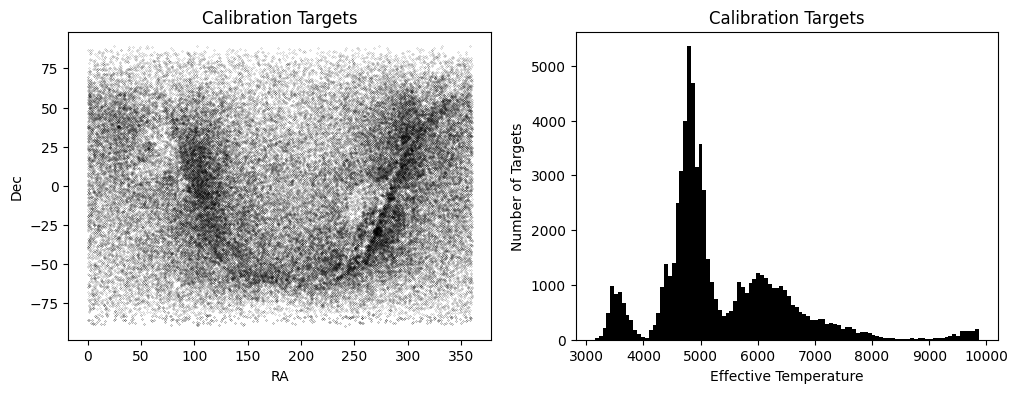

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(df1.ra, df1.dec, s=0.01, c='k')
ax[1].hist(df1.teff_gspphot.values, 100, color='k');
ax[0].set(xlabel="RA", ylabel="Dec", title="Calibration Targets")
ax[1].set(xlabel="Effective Temperature", ylabel="Number of Targets", title="Calibration Targets")